<a href="https://colab.research.google.com/github/IFibla/Aprenentatge-Automatic/blob/master/Problema%201/Individual-%C2%BFKullback-que%3F/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ¿Kullback que?

Cuando trabajamos con modelos que representan una distribución de probabilidad nuestro objetivo es hacer que la distribución de los datos se acerque lo más posible a las probabilidades que nos da el modelo sobre esos datos. Existen muchas maneras de calcular esa diferencia, una común es usar funciones de divergencia, entre ellas la divergencia de Kullback-Leibler es la más usada. Dadas dos distribuciones de probabilidad 𝑃 y 𝑄 se define asumiendo que sean distribuciones discretas como:

$$
KL(P|Q)=\sum_{i=1}^{N}P(i)\cdot \log(\frac{P(i)}{Q(i)}) 
$$

En el caso de distribuciones continuas, simplemente substituimos el sumatorio por una integral.



In [2]:
%load_ext autoreload
%autoreload 2

In [54]:
from jax import grad, jit, vmap
from sklearn.datasets import make_classification, make_circles
import jax.numpy as np
import matplotlib.pyplot as plt
import sklearn
import math

In [94]:
RANDOM_STATE = 100

## Utils

In [5]:
def resize_make_classification_list(in_list):
  out_list = []
  for i in range(len(in_list[0])):
    out_list.append([l[i] for l in in_list])
  return out_list

In [6]:
def plot_profile(profile, xlabel='', ylabel='', xlim=None, ylim=None, color=None, fill=True, annotate=None, title=None, hlines=None, vertical_strips=None):
  fig, ax1 = plt.subplots(figsize=(18,4))
  if xlim: plt.xlim(xlim)

  ax1.set_xlabel(xlabel)

  color = color if color else 'tab:blue'
  ax1.set_ylabel(ylabel)
  ax1.plot(profile['X'], profile['Y'], color=color)
  if fill: plt.fill_between(profile['X'], profile['Y'], color=color, alpha=0.2)
  if ylim: plt.ylim(ylim)
  
  if title: plt.title(title)
  
  if vertical_strips:
      for (a,b) in vertical_strips:
          plt.axvspan(a, b, alpha=0.75, color='#E79900')
  
  if hlines:
      for h in hlines:
          plt.axhline(y=h, color='grey', linestyle='--', alpha=0.8, linewidth=1)

In [79]:
def plot_binary_scatters (f_scatter, t_scatter, xlabel='', ylabel='', xlim=None, ylim=None, color=['tab:red', 'tab:green'], fill=True, annotate=None, title=None, hlines=None):
  fig, ax1 = plt.subplots(figsize=(8,8))
  ax1.set_xlabel(xlabel)
  ax1.set_ylabel(ylabel)
  ax1.scatter(f_scatter['X'], f_scatter['Y'], c=color[0])
  ax1.scatter(t_scatter['X'], t_scatter['Y'], c=color[1])  
  if title: plt.title(title)

In [84]:
def plot_binary_scatters_and_profile (f_scatter, t_scatter, profile, xlabel='', ylabel='', xlim=None, ylim=None, color=['tab:red', 'tab:green', 'tab:blue'], fill=True, annotate=None, title=None, hlines=None):
  fig, ax1 = plt.subplots(figsize=(8,8))
  ax1.set_xlabel(xlabel)
  ax1.set_ylabel(ylabel)
  ax1.scatter(f_scatter['X'], f_scatter['Y'], c=color[0])
  ax1.scatter(t_scatter['X'], t_scatter['Y'], c=color[1])  
  ax1.plot(profile['X'], profile['Y'], color=color[2])
  if title: plt.title(title)
  if ylim: plt.ylim(ylim)

In [7]:
def generate_matplotlib_histogram(X, labelX, labelY, title, rangeX=None, rangeY=None, bins=30):
  if rangeX is None: 
    rangeX = [np.min(X), np.max(X)]
  plt.hist(X, bins=bins, alpha=1, range=rangeX, density=True, stacked=True)  
  plt.xlabel(labelX)
  plt.ylabel(labelY)
  plt.title(title)
  if rangeY is not None:
    plt.ylim((rangeY[0], rangeY[1]))
  plt.legend([len(x) for x in X] if len(X) > 1 else "X")
  plt.show()

In [52]:
def gradient_descend ( loss_function, init_var, x, in_axes, epochs=1000, epsilon=1e-10, learning_rate=0.001, verbose=False ):
  loss_history = []
  grad_func = jit ( grad ( loss_function ) )
  vmap_grad_func = vmap( grad_func, in_axes=in_axes )
  
  vmap_func = vmap( loss_function, in_axes=in_axes )
  loss_history.append(vmap_func(x, init_var).mean(0))

  for i in range(epochs):
    part = vmap_grad_func(x, init_var)
    init_var -= (learning_rate * part.mean(0).mean(0))
    loss_history.append(vmap_func(x, init_var).mean(0))
    if np.abs(loss_history[-2] - loss_history[-1]) <= epsilon or math.isnan(loss_history[-1]):
      break
    if verbose: print("Epoch", i, ": init_var =", init_var, "loss =", loss_history[-1], "\r")
  return init_var, loss_history

> Siendo 𝑋 una muestra de datos 𝑥1, ... , 𝑥𝑛 de valores discretos, donde podemos estimar su distribución 𝑃 a partir de su frecuencia y 𝑄 es una distribución de probabilidad sobre el mismo rango de valores discretos. Demuestra que optimizar 𝐾 𝐿(𝑃 |𝑄) es equivalente a optimizar la log verosimilitud negativa de 𝑄 sobre los datos.

In [9]:
a_minus_log_verosimilitud_q = lambda P: sum(1/np.log(P)) - (len(P) * np.log(len(P)))
a_diff_minus_log_verosimilitud_q = lambda P: sum(1/np.log(P))

a_optimise_kl = lambda P: (len(P) + len(P) * np.log(len(P))) * sum(P)
a_diff_optimise_kl = lambda P: (len(P) + len(P) * np.log(len(P))) * sum(P)

> Todo modelo de clasificación es una distribución de probabilidad sobre un conjunto de valores discretos, por lo que podemos ajustar un modelo probabilístico para clasificación haciendo que las probabilidades que obtenga para una muestra se ajusten a las de los datos. Usa la función make_classification de scikit-learn para crear un conjunto de datos de clasificación de dos dimensiones y 100 ejemplos. Tendrás dar un valor 0 al parámetro n_redundant y un valor 1 al parámetro n_clusters_per_class. Da un valor también al parámetro random_state para que los experimentos sean reproducibles. El problema que generará será de clasificación binaria.

[Documentation. make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)


In [95]:
b_sample = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=RANDOM_STATE)
b_sample_prob = b_sample[0]
b_sample_label = b_sample[1]
b_sample_prob[:5], b_sample_label[:5]

(array([[ 1.01140791, -1.02987613],
        [-0.99420258,  0.80954843],
        [-1.04912891,  1.43302765],
        [ 1.80795989, -0.53074909],
        [ 0.43541821, -0.99272674]]), array([0, 1, 1, 0, 0]))

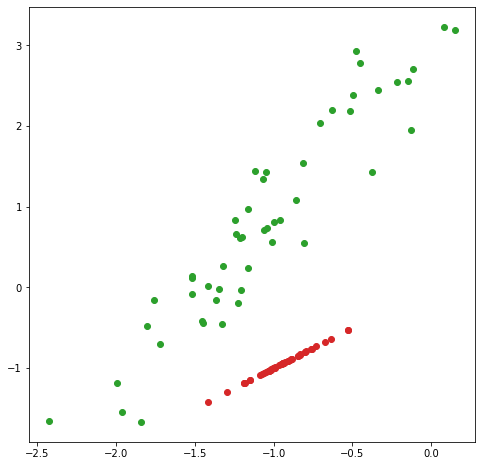

In [96]:
true_x = [x[0] for idx, x in enumerate(b_sample_prob) if b_sample_label[idx]]
true_y = [x[1] for idx, x in enumerate(b_sample_prob) if b_sample_label[idx]]
false_x = [x[1] for idx, x in enumerate(b_sample_prob) if not b_sample_label[idx]]
false_y = [x[1] for idx, x in enumerate(b_sample_prob) if not b_sample_label[idx]]

t_scat = {'X': true_x, 'Y': true_y}
f_scat = {'X': false_x, 'Y': false_y}

plot_binary_scatters(f_scat, t_scat)

> Podemos crear un modelo probabilístico con una función linear $f(w,x)=w\cdot x$. Para obtener probabilidades simplemente tenemos que aplicar sobre el resultado una función que de un valor entre 0 y 1. Por ejemplo la función sigmoide 𝜎:
>
> $σ(x)=\frac{1}{1+e^x}$
>
> A partir de la divergencia de Kullback-Leibler simplificando para problemas binarios podemos llegar a la función de pérdida de entropía cruzada binaria (binary cross entropy):
>
> $BCE(p(x), y )=y \cdot \log(p(x)) + (1-y) \cdot \log(1-p(x))$
>
> Donde 𝑝(𝑥) es la probabilidad que le asigna el modelo a un ejemplo, e 𝑦 es la etiqueta que le corresponde a los datos. Implementa un algoritmo de descenso de gradiente usando JAX con la función de entropía cruzada binaria. Explora diferentes tasas de aprendizaje. Comenta lo que observes en el comportamiento del error y los parámetros durante la optimización. Escoge un número de iteraciones y un valor para decidir el final de la optimización que te parezcan adecuados.

[Documentation. jax.grad](https://jax.readthedocs.io/en/latest/_autosummary/jax.grad.html)

In [97]:
c_dataset = np.array([[x[0], x[1], y] for x, y in zip(b_sample_prob, b_sample_label)])

In [98]:
c_sigmoid_function = lambda x: 1 / (1 + np.exp(x))
c_linear_function = lambda w, x: w[0] * x + w[1]
c_cross_binary_entropy = lambda Px, y: y * np.log(Px) + ((1 - y) * np.log(1-Px))
c_linear_cross_binary_entropy = lambda w, x: c_cross_binary_entropy ( c_sigmoid_function( c_linear_function(w[0:2], x) ), w[2] )

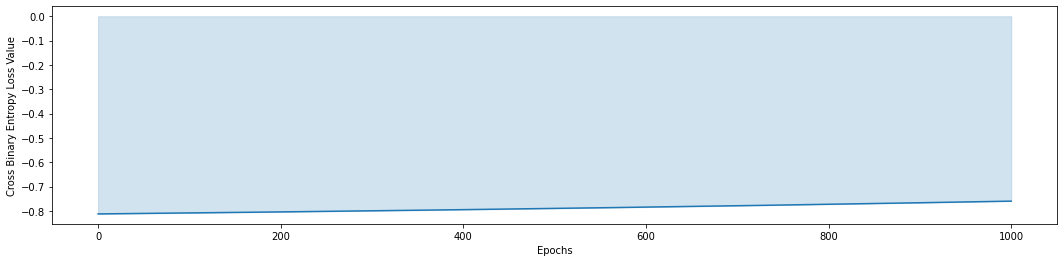

In [109]:
final_val, loss_history = gradient_descend(c_linear_cross_binary_entropy,
                                            0.9,
                                            c_dataset,
                                            (0, None),
                                            epochs=1000,
                                            learning_rate=0.01,
                                            verbose=False)
loss_history_profile = {'X': range(len(loss_history)), 'Y': loss_history}
plot_profile(loss_history_profile, xlabel="Epochs", ylabel='Cross Binary Entropy Loss Value')

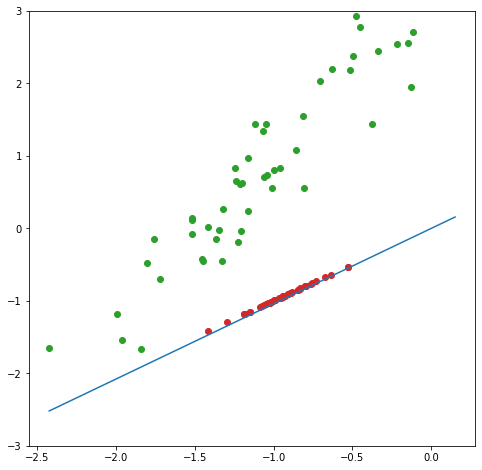

In [110]:
p_min = min(min(true_x), min(false_x))
p_max = max(max(true_x), max(false_x))

profileX = np.linspace(p_min, p_max, 50)
profileY = [final_val * x for x in profileX]
profile = {'X': profileX, 'Y': profileY}

plot_binary_scatters_and_profile(f_scat, t_scat, profile, ylim=[-3, 3])

In [20]:
grad_func = jit ( grad ( c_linear_cross_binary_entropy ) )
vmap_func = vmap( grad_func, in_axes=(0, None) )
vmap_func2 = vmap( c_linear_cross_binary_entropy, in_axes=(0, None) )
print((vmap_func(c_dataset, 2))[:2])
print((vmap_func2(c_dataset, 2))[:2])

[[-0.45575705 -0.22787853  1.2203293 ]
 [ 0.13176757  0.06588379 -2.6517086 ]]
[-0.25861338 -0.06815439]


> Genera un conjunto de datos con la función make_circles de scikit-learn usando el valor 0,1 para el parámetro noise. Optimiza el modelo para varios parámetros iniciales diferentes del modelo. Cuenta que esta que sucediendo e intenta explicar el porqué.

[Documentation. sklearn.datasets.make_circles](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html)

In [58]:
d_sample = make_circles(n_samples=100, noise=0.1, random_state=RANDOM_STATE)
d_sample_prob = d_sample[0]
d_sample_label = d_sample[1]
d_sample_prob[:5], d_sample_label[:5]

(array([[-0.63640493, -0.36870191],
        [-0.24465976, -0.73659196],
        [-0.46597138, -1.06687743],
        [-0.70999784, -0.40841948],
        [ 0.70232238, -0.51730147]]), array([1, 1, 0, 1, 1]))

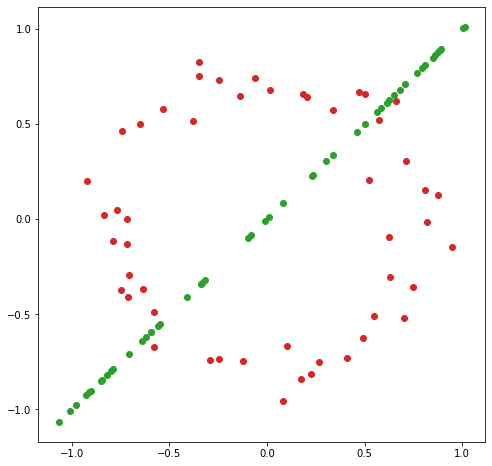

In [88]:
d_true_x = [x[0] for idx, x in enumerate(d_sample_prob) if d_sample_label[idx]]
d_true_y = [x[1] for idx, x in enumerate(d_sample_prob) if d_sample_label[idx]]
d_false_x = [x[1] for idx, x in enumerate(d_sample_prob) if not d_sample_label[idx]]
d_false_y = [x[1] for idx, x in enumerate(d_sample_prob) if not d_sample_label[idx]]

d_t_scat = {'X': d_true_x, 'Y': d_true_y}
d_f_scat = {'X': d_false_x, 'Y': d_false_y}

plot_binary_scatters(d_t_scat, d_f_scat)

> La función de entropía cruzada parece una función extraña para optimizar cuando lo que nos interesa es un modelo que tenga el mínimo número de ejemplos mal clasificados. En este caso se correspondería a la función de pérdida 0/1, que en el caso de probabilidades asignaría una pérdida de 0 a valores menores que 0.5 y 1 en caso contrario ¿Porqué no es una buena idea optimizar directamente esta función? Representa las dos funciones.

In [64]:
e_binary_loss_function = lambda Px: (Px < 0.5)
e_linear_binary_loss_function = lambda w, x: e_binary_loss_function(c_sigmoid_function(c_linear_function(w[0:2], x))).astype(float)

In [61]:
e_dataset = np.array([[x[0], x[1], y] for x, y in zip(d_sample_prob, d_sample_label)])

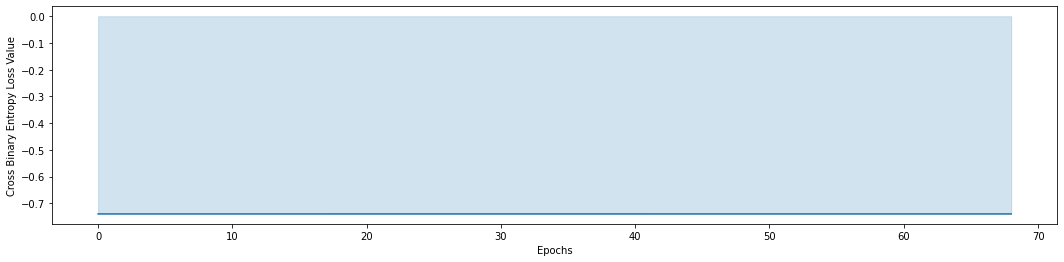

In [89]:
e_final_val, loss_history = gradient_descend(c_linear_cross_binary_entropy,
                                            0,
                                            e_dataset,
                                            (0, None),
                                            epochs=1000,
                                            learning_rate=0.1,
                                            verbose=False)
loss_history_profile = {'X': range(len(loss_history)), 'Y': loss_history}
plot_profile(loss_history_profile, xlabel="Epochs", ylabel='Cross Binary Entropy Loss Value')

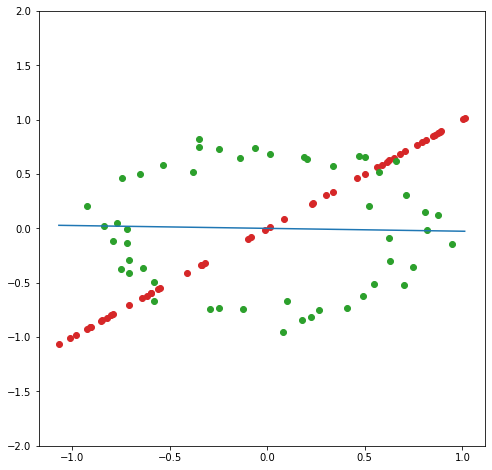

In [91]:
p_min = min(min(d_true_x), min(d_false_x))
p_max = max(max(d_true_x), max(d_false_x))

profileX = np.linspace(p_min, p_max, 50)
profileY = [e_final_val * x for x in profileX]
profile = {'X': profileX, 'Y': profileY}

plot_binary_scatters_and_profile(f_scat, t_scat, profile, ylim=[-2, 2])

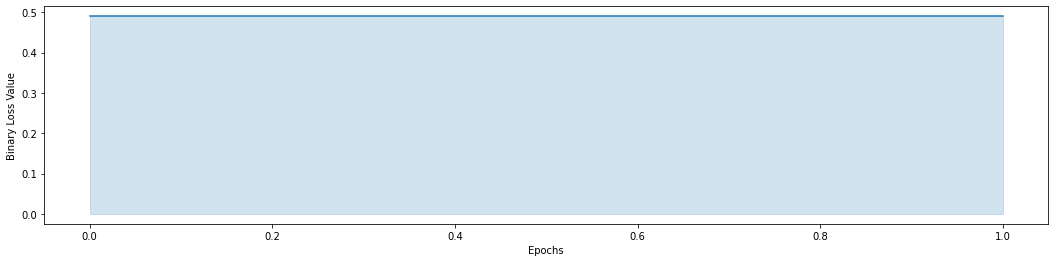

In [92]:
e2_final_val, loss_history = gradient_descend(e_linear_binary_loss_function,
                                            0,
                                            e_dataset,
                                            (0, None),
                                            epochs=1000,
                                            learning_rate=0.1,
                                            verbose=False)
loss_history_profile = {'X': range(len(loss_history)), 'Y': loss_history}
plot_profile(loss_history_profile, xlabel="Epochs", ylabel='Binary Loss Value')

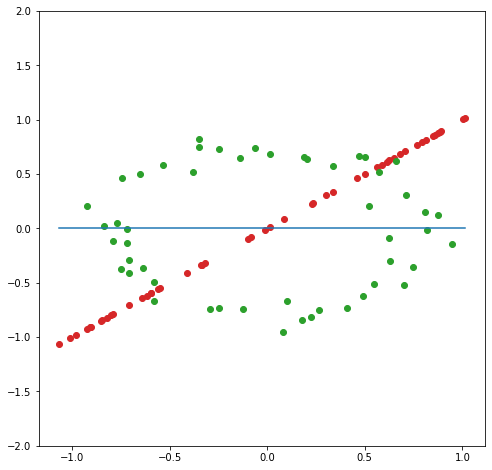

In [93]:
p_min = min(min(d_true_x), min(d_false_x))
p_max = max(max(d_true_x), max(d_false_x))

profileX = np.linspace(p_min, p_max, 50)
profileY = [e2_final_val * x for x in profileX]
profile = {'X': profileX, 'Y': profileY}

plot_binary_scatters_and_profile(f_scat, t_scat, profile, ylim=[-2, 2])